In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cremad/AudioWAV/1028_TSI_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1075_IEO_HAP_LO.wav
/kaggle/input/cremad/AudioWAV/1084_ITS_HAP_XX.wav
/kaggle/input/cremad/AudioWAV/1067_IWW_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1066_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1027_DFA_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav
/kaggle/input/cremad/AudioWAV/1023_TIE_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1041_TAI_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1004_WSI_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1030_DFA_HAP_XX.wav
/kaggle/input/cremad/AudioWAV/1037_WSI_NEU_XX.wav
/kaggle/input/cremad/AudioWAV/1006_IOM_FEA_XX.wav
/kaggle/input/cremad/AudioWAV/1053_IEO_HAP_LO.wav
/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav
/kaggle/input/cremad/AudioWAV/1055_TSI_SAD_XX.wav
/kaggle/input/cremad/AudioWAV/1019_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1014_TAI_ANG_XX.wav
/kaggle/input/cremad/AudioWAV/1087_TIE_DIS_XX.wav
/kaggle/input/cremad/AudioWAV/1009_IWW_DIS_XX.wav


In [5]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


In [6]:
# 2. Dataset paths (Kaggle-style)
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [7]:
# 3. Read and label datasets
def load_ravdess():
    emotion_map = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
    files = []
    for dir in os.listdir(Ravdess):
        for file in os.listdir(Ravdess + dir):
            emotion = int(file.split('-')[2])
            files.append((emotion_map[emotion], Ravdess + dir + '/' + file))
    return pd.DataFrame(files, columns=['Emotions', 'Path'])

def load_crema():
    files = []
    for file in os.listdir(Crema):
        emotion = file.split('_')[2]
        emo_map = {'SAD':'sad', 'ANG':'angry', 'DIS':'disgust', 'FEA':'fear', 'HAP':'happy', 'NEU':'neutral'}
        if emotion in emo_map:
            files.append((emo_map[emotion], Crema + file))
    return pd.DataFrame(files, columns=['Emotions', 'Path'])

def load_tess():
    files = []
    for folder in os.listdir(Tess):
        for file in os.listdir(Tess + folder):
            emotion = file.split('_')[2].replace('.wav', '')
            emotion = 'surprise' if emotion == 'ps' else emotion
            files.append((emotion, Tess + folder + '/' + file))
    return pd.DataFrame(files, columns=['Emotions', 'Path'])

def load_savee():
    files = []
    emo_map = {'a':'angry', 'd':'disgust', 'f':'fear', 'h':'happy', 'n':'neutral', 'sa':'sad', 'su':'surprise'}
    for file in os.listdir(Savee):
        key = file.split('_')[1][:-6]
        if key in emo_map:
            files.append((emo_map[key], Savee + file))
    return pd.DataFrame(files, columns=['Emotions', 'Path'])

# Combine all
data_path = pd.concat([load_ravdess(), load_crema(), load_tess(), load_savee()], ignore_index=True)
data_path = data_path[data_path['Path'].notna()]


In [8]:
# 4. Feature extraction
def extract_features(file_path):
    data, sr = librosa.load(file_path, duration=2.5, offset=0.6)
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

X, Y = [], []
for emotion, path in data_path.values:
    try:
        features = extract_features(path)
        X.append(features)
        Y.append(emotion)
    except Exception as e:
        continue

X = np.array(X)
Y = np.array(Y)


In [9]:
# 5. Label encoding & train-test split
encoder = LabelEncoder()
Y_encoded = encoder.fit_transform(Y)
Y_categorical = to_categorical(Y_encoded, num_classes=len(encoder.classes_))

x_train, x_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.2, random_state=42, shuffle=True)

# Standardize
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)


In [10]:
# 6. Model
model = Sequential()
model.add(Conv1D(256, 5, activation='relu', padding='same', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, 5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1751225778.391343      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751225778.392006      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 40, 256)             │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 20, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227,592 (889.03 KB)

 Trainable params: 227,592 (889.03 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 7. Training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, patience=2, verbose=1, min_lr=1e-6)

history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[checkpoint, rlrp])


Epoch 1/50


I0000 00:00:1751225793.652792     133 service.cc:148] XLA service 0x7ad4500045f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751225793.653237     133 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751225793.653258     133 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751225793.980834     133 cuda_dnn.cc:529] Loaded cuDNN version 90300


 58/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2433 - loss: 1.8648

I0000 00:00:1751225796.567333     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3081 - loss: 1.7392
Epoch 1: val_accuracy improved from -inf to 0.46897, saving model to best_model.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.3085 - loss: 1.7382 - val_accuracy: 0.4690 - val_loss: 1.3852 - learning_rate: 0.0010
Epoch 2/50
142/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4727 - loss: 1.3685
Epoch 2: val_accuracy improved from 0.46897 to 0.50719, saving model to best_model.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4742 - loss: 1.3652 - val_accuracy: 0.5072 - val_loss: 1.2658 - learning_rate: 0.0010
Epoch 3/50
137/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5062 - loss: 1.2680
Epoch 3: val_accuracy improved from 0.50719 to 0.51541, saving model to best_model.h5
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5078 - loss: 1.2638 - val_accuracy: 0.5154 - val_loss: 1.2160 - learning_rate: 0.0010
Epoch 4/50
150/153 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5347 - 

In [15]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"\n✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"❌ Test Loss: {test_loss:.4f}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5901 - loss: 2.5396

✅ Test Accuracy: 59.23%
❌ Test Loss: 2.5470


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Classification Report:
               precision    recall  f1-score   support

       angry       0.70      0.69      0.69       361
        calm       0.73      0.64      0.68        42
     disgust       0.53      0.50      0.52       414
        fear       0.51      0.55      0.53       373
       happy       0.55      0.53      0.54       385
     neutral       0.56      0.59      0.58       344
         sad       0.60      0.61      0.60       388
    surprise       0.90      0.86      0.88       126

    accuracy                           0.59      2433
   macro avg       0.64      0.62      0.63      2433
weighted avg       0.59      0.59      0.59      2433



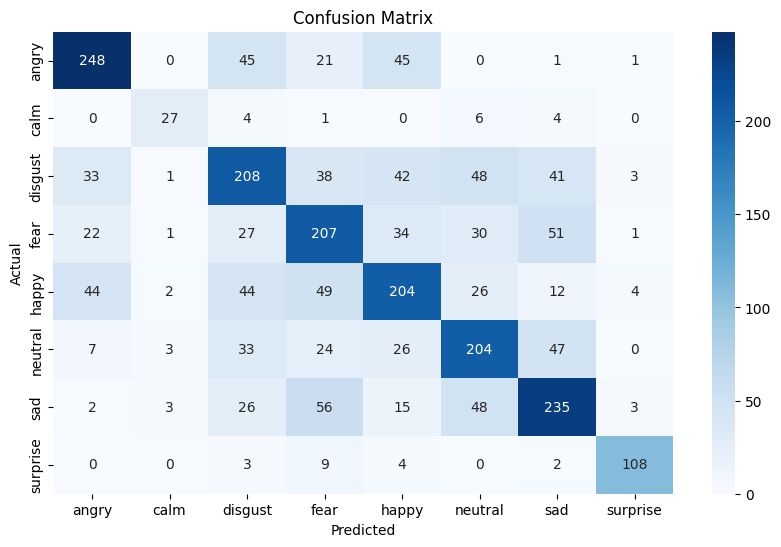

In [12]:
# 8. Evaluation
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred_labels, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, xticklabels=encoder.classes_, yticklabels=encoder.classes_, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# 1. Predict on test data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 2. Convert indices to emotion names
y_pred_emotions = encoder.inverse_transform(y_pred_labels)
y_true_emotions = encoder.inverse_transform(y_true_labels)

# 3. Print some comparisons
print("🔍 Sample Predictions vs Ground Truth:\n")
for i in range(10):
    print(f"👉 True: {y_true_emotions[i]:<10} | Predicted: {y_pred_emotions[i]}")


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔍 Sample Predictions vs Ground Truth:

👉 True: fear       | Predicted: fear
👉 True: neutral    | Predicted: sad
👉 True: sad        | Predicted: sad
👉 True: disgust    | Predicted: disgust
👉 True: sad        | Predicted: sad
👉 True: disgust    | Predicted: disgust
👉 True: happy      | Predicted: happy
👉 True: disgust    | Predicted: disgust
👉 True: sad        | Predicted: sad
👉 True: happy      | Predicted: angry


In [14]:
from sklearn.metrics import classification_report

print("📋 Classification Report:\n")
print(classification_report(y_true_labels, y_pred_labels, target_names=encoder.classes_))


📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.70      0.69      0.69       361
        calm       0.73      0.64      0.68        42
     disgust       0.53      0.50      0.52       414
        fear       0.51      0.55      0.53       373
       happy       0.55      0.53      0.54       385
     neutral       0.56      0.59      0.58       344
         sad       0.60      0.61      0.60       388
    surprise       0.90      0.86      0.88       126

    accuracy                           0.59      2433
   macro avg       0.64      0.62      0.63      2433
weighted avg       0.59      0.59      0.59      2433

